In [1]:
import os, sys, time

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, Function

import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import pylab
import matplotlib.pyplot as plt

from scipy.misc import imread, imresize
from scipy.stats import pearsonr

from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist

from invert import invert

from indexdata import load_image_to_label
from indexdataset import load_image_dataset_label_index
from voclabels import voc_labels

import loadseg
import expdir
import intersect
import upsample
from labelprobe import cached_memmap

import sys
from viewprobe import NetworkProbe

import matplotlib
from matplotlib.ticker import FuncFormatter

from linearprobe_pytorch import CustomLayer

from figures import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pylab as pylab
params = {'axes.labelsize': 16,
         'axes.titlesize':16,
         'xtick.labelsize':14,
         'ytick.labelsize':14,
         'legend.fontsize':14}
pylab.rcParams.update(params)

In [3]:
gpu = 1

cuda = True if gpu is not None else False
use_mult_gpu = isinstance(gpu, list)
if cuda:
    if use_mult_gpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu).strip('[').strip(']')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = '%d' % gpu
print(torch.cuda.device_count(), use_mult_gpu, cuda)

(1L, False, True)


In [4]:
blob_names = {
    'features.1': 'relu1',
    'features.4': 'relu2',
    'features.7': 'relu3',
    'features.9': 'relu4',
    'features.11': 'relu5',
    'features': 'pool5'
}

In [5]:
directory='/home/ruthfong/NetDissect/probes/pytorch_alexnet_imagenet'
if not os.path.exists(directory):
    directory='/scratch/shared/slow/ruthfong/pytorch_alexnet_imagenet'
    assert(os.path.exists(directory))
blob='features.11'

In [6]:
ed = expdir.ExperimentDirectory(directory)

info = ed.load_info()
ds = loadseg.SegmentationData(info.dataset)
categories = np.array(ds.category_names())

L = ds.label_size()
N = ds.size()

label_names = np.array([ds.label[i]['name'] for i in range(L)])

blob_info = ed.load_info(blob=blob)
shape = blob_info.shape
K = shape[1]

In [7]:
blobs = ['features.1', 'features.4', 'features.7', 'features.9', 'features.11']

suffix=''

linear_ind_ious = {}
single_ind_ious = {}
linear_set_ious = {}
weights = {}

single_set_train_ious = {}
single_set_val_ious = {}

for blob in blobs:
    blob_info = ed.load_info(blob=blob)
    shape = blob_info.shape
    K = shape[1]
    linear_ind_ious[blob] = ed.open_mmap(blob=blob, part='linear_ind_ious', mode='r', dtype='float32', shape=(L,N))
    single_ind_ious[blob] = ed.open_mmap(blob=blob, part='single_ind_ious', mode='r', dtype='float32', suffix=suffix, shape=(L,N,K))
    linear_set_ious[blob] = ed.open_mmap(blob=blob, part='linear_set_val_ious', mode='r', dtype='float32', shape=(L,))
    single_set_train_ious[blob] = ed.open_mmap(blob=blob, part='single_set_train_ious', mode='r', dtype='float32', suffix=suffix, shape=(L,K))
    single_set_val_ious[blob] = ed.open_mmap(blob=blob, part='single_set_val_ious', mode='r', dtype='float32', suffix=suffix, shape=(L,K))
    weights[blob] = ed.open_mmap(blob=blob, part='linear_weights', mode='r', dtype='float32', shape=(L,K))

In [8]:
thresh = {}
quantile = 0.005
qcode = ('%f' % quantile).replace('0.','').rstrip('0')
blobdata = {}

for blob in blobs: 
    blob_info = ed.load_info(blob=blob)
    shape = blob_info.shape
    K = shape[1]
    
    quantdata = ed.open_mmap(blob=blob, part='quant-*', shape=(K, -1))
    threshold = quantdata[:, int(round(quantdata.shape[1] * quantile))]
    thresh[blob] = np.copy(threshold[:, np.newaxis, np.newaxis])
    blobdata[blob] = ed.open_mmap(blob=blob, mode='r', dtype='float32', shape=shape)

In [9]:
train_idx = np.array([ds.split(i) == 'train' for i in range(N)])
val_idx = np.array([ds.split(i) == 'val' for i in range(N)])
train_ind = np.array([True if ds.split(i) == 'train' else False for i in range(N)])
val_ind = np.array([True if ds.split(i) == 'val' else False for i in range(N)])

In [10]:
image_to_label = load_image_to_label(directory)
pc = ds.primary_categories_per_index()
pc[0] = -1

In [11]:
suffix = '_lr_1e-1_sgd_quant_1_epochs_30_iter_15_num_filters_2'
F = 2
epochs = 30

disc_weights = {}
disc_bias = {}
disc_results = {}

for blob in blobs:
    blob_info = ed.load_info(blob=blob)
    shape = blob_info.shape
    K = shape[1]
    disc_weights[blob] = ed.open_mmap(blob=blob, part='linear_weights_disc%s' % suffix, mode='r', dtype='float32', shape=(L, F, K))
    disc_bias[blob] = ed.open_mmap(blob=blob, part='linear_bias_disc%s' % suffix, mode='r', dtype='float32', shape=(L, F))
    disc_results[blob] = ed.open_mmap(blob=blob, part='linear_results_disc%s' % suffix, mode='r', dtype='float32', shape=(L, F, 4, epochs))

In [12]:
suffix = '_lr_1e-1_sgd_quant_1_epochs_30_iter_15_num_filters'
num_filters = [1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 80, 100, 128]
F = len(num_filters) + 1

disc_weights_all = {}
disc_bias_all = {}
disc_results_all = {}

for blob in blobs[2:]:
    blob_info = ed.load_info(blob=blob)
    shape = blob_info.shape
    K = shape[1]

    disc_weights_all[blob] = ed.open_mmap(blob=blob, part='linear_weights_disc%s' % suffix, mode='r', dtype='float32', shape=(L, F, K))
    disc_bias_all[blob] = ed.open_mmap(blob=blob, part='linear_bias_disc%s' % suffix, mode='r', dtype='float32', shape=(L, F))
    disc_results_all[blob] = ed.open_mmap(blob=blob, part='linear_results_disc%s' % suffix, mode='r', dtype='float32', shape=(L, F, 4, epochs))

In [13]:
directory_in = '/scratch/shared/slow/ruthfong/pytorch_alexnet_imagenet12/train'
ed_in = expdir.ExperimentDirectory(directory_in)
L_in = 1000
epochs = 30

suffix = '_lr_1e-1_sgd_quant_1_epochs_30_iter_15_take_2'

disc_weights_in = {}
disc_bias_in = {}
disc_results_in = {}

for blob in [blobs[-1]]:
    blob_info = ed_in.load_info(blob=blob)
    shape = blob_info.shape
    K = shape[1]

    disc_weights_in[blob] = ed_in.open_mmap(blob=blob, part='linear_weights_disc%s' % suffix, mode='r', shape=(L_in,1,K))
    disc_bias_in[blob] = ed_in.open_mmap(blob=blob, part='linear_bias_disc%s' % suffix, mode='r', shape=(L_in,1))
    disc_results_in[blob] = ed_in.open_mmap(blob=blob, part='linear_results_disc%s' % suffix, mode='r', shape=(L_in,1,4, epochs))


In [14]:
label_names_in = np.loadtxt('synset_words.txt', str, delimiter='\n')
label_short_names_in = [' '.join(l.split(' ')[1:]).split(',')[0] for l in label_names_in]

In [15]:
top = {}
imgmax = {}
for blob in blobs:
    blob_info = ed.load_info(blob=blob)
    imgmax[blob] = ed.open_mmap(blob=blob, part='imgmax', mode='r', shape=blob_info.shape[:2])
    top[blob] = imgmax[blob].argsort(axis=0).transpose()[::-1]

In [16]:
def show_image(img_path):
    f, ax = plt.subplots(1,1)
    ax.imshow(imread(img_path))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

# Concept Embeddings

In [90]:
import word2vec
from word2vec import WordVectors

In [251]:
blob = 'features.11'

norm_weights = np.array([np.true_divide(disc_weights[blob][i,-1,:],np.linalg.norm(disc_weights[blob][i,-1,:])) for i in range(L)])
wv_disc = WordVectors(vocab=label_names[1:], vectors=np.copy(norm_weights[1:]))

norm_weights_in = np.array([np.true_divide(disc_weights_in[blob][i,-1,:], np.linalg.norm(disc_weights_in[blob][i,-1,:])) 
                         for i in range(L_in)])
wv_disc_in = WordVectors(vocab=label_short_names_in, vectors=np.copy(norm_weights_in))

comb_labels = np.concatenate((label_names[1:], label_short_names_in))
wv_disc_comb = WordVectors(vocab=comb_labels, 
                           vectors=np.concatenate((norm_weights, norm_weights_in)))

/users/ruthfong/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


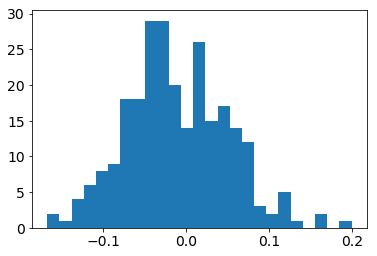

In [142]:
f, ax = plt.subplots(1,1)
ax.hist(norm_weights[256], bins=25)
plt.show()

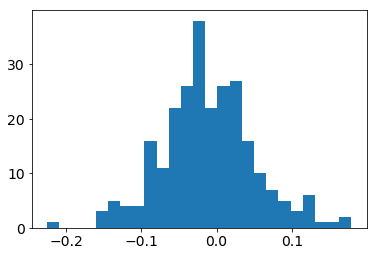

In [143]:
f, ax = plt.subplots(1,1)
ax.hist(norm_weights_in[256], bins=25)
plt.show()

In [106]:
np.mean(disc_results_in[blob][:,0,-1,-1])

0.49678558

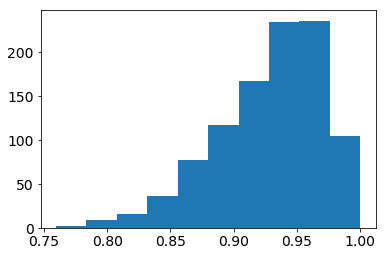

In [144]:
f, ax = plt.subplots(1,1)
ax.hist(disc_results_in[blob][:,0,-1,-1])
plt.show()

In [148]:
from indexdata import load_image_to_label

label_i = 19

image_to_label_train = load_image_to_label(directory_in, blob=blob)
train_label_idx = np.where(image_to_label_train[:,label_i])

In [150]:
indexes, metrics = wv_disc_in.cosine('tree frog')
for i in range(len(indexes)):
    print wv_disc_in.vocab[indexes[i]], metrics[i] 
#wv_disc_in.generate_response(indexes, metrics).tolist()

tailed frog 0.528851
bullfrog 0.47178
banded gecko 0.40215
green lizard 0.382657
African chameleon 0.381823
American chameleon 0.371628
alligator lizard 0.344459
cricket 0.338535
mantis 0.321173
grasshopper 0.32043


In [158]:
nearest_in_idx = np.zeros(L)
nearest_in_dist = np.zeros(L)

for label_i in range(1,L):
    indexes, metrics = wv_disc_comb.cosine(label_names[label_i], n=L + L_in)
    wv_disc_comb.generate_response(indexes, metrics).tolist()
    ind = np.where(indexes > L-1)[0][0]
    nearest_in_idx[label_i] = ind
    nearest_in_dist[label_i] = metrics[ind]

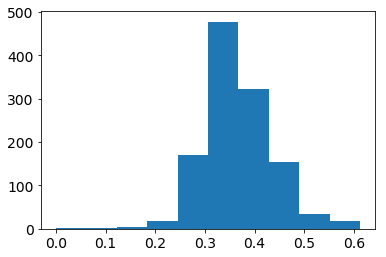

In [159]:
f, ax = plt.subplots(1,1)
ax.hist(nearest_in_dist)
plt.show()

In [168]:
filters_range = [1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 80, 100, 128, 256]

approx_filters = np.zeros(L)

for label_i in range(1,L):
    top_perf = disc_results_all[blob][label_i,-1,-1,-1]
    try:
        approx_filters[label_i] = filters_range[np.where(disc_results_all[blob][label_i,:,-1,-1] > (0.9*(top_perf-0.50) + 0.50))[0][0]]
    except:
        approx_filters[label_i] = filters_range[-1]

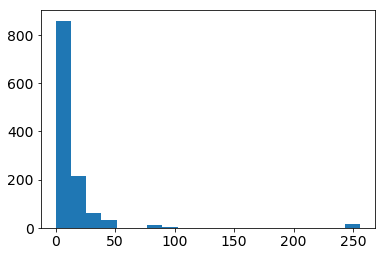

In [170]:
f, ax = plt.subplots(1,1)
ax.hist(approx_filters, bins=20)
plt.show()

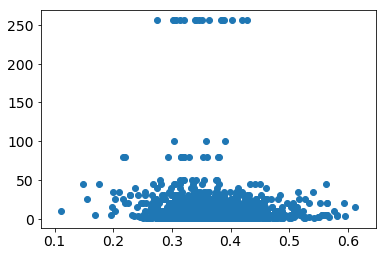

In [171]:
f, ax = plt.subplots(1,1)
ax.scatter(nearest_in_dist[1:], approx_filters[1:])
plt.show()

In [188]:
nearest_in_dist[np.where(approx_filters == 1)[0]]

array([ 0.43474871,  0.37693888,  0.36068338,  0.40118378,  0.40297481,
        0.34069335,  0.42530504,  0.36044082,  0.31960869,  0.34094501,
        0.42802078,  0.26251006,  0.44271809,  0.48384577,  0.47279623,
        0.28493372,  0.33824182,  0.37602285,  0.38834429,  0.44647369,
        0.35672337,  0.28651798,  0.52603084,  0.3341074 ,  0.34699172,
        0.35845995,  0.35098332,  0.34921655,  0.34868962,  0.4445352 ,
        0.35511017,  0.40415037,  0.32306576,  0.41050017,  0.37436599,
        0.41378137,  0.36744338,  0.41981715,  0.46050158,  0.50046736,
        0.32576573,  0.31970128,  0.42973664,  0.28659746,  0.30420414,
        0.38422555,  0.35724512,  0.48782367,  0.35271713,  0.3546983 ,
        0.47752833,  0.39555192,  0.40290296,  0.35729575,  0.39091188,
        0.4032394 ,  0.27438039,  0.33331656,  0.38129961,  0.43866903,
        0.38701028,  0.3306855 ,  0.34035698,  0.36968723,  0.37309775,
        0.35706216,  0.39016938,  0.34462541,  0.35370493,  0.36

In [192]:
len(filters_range)

17

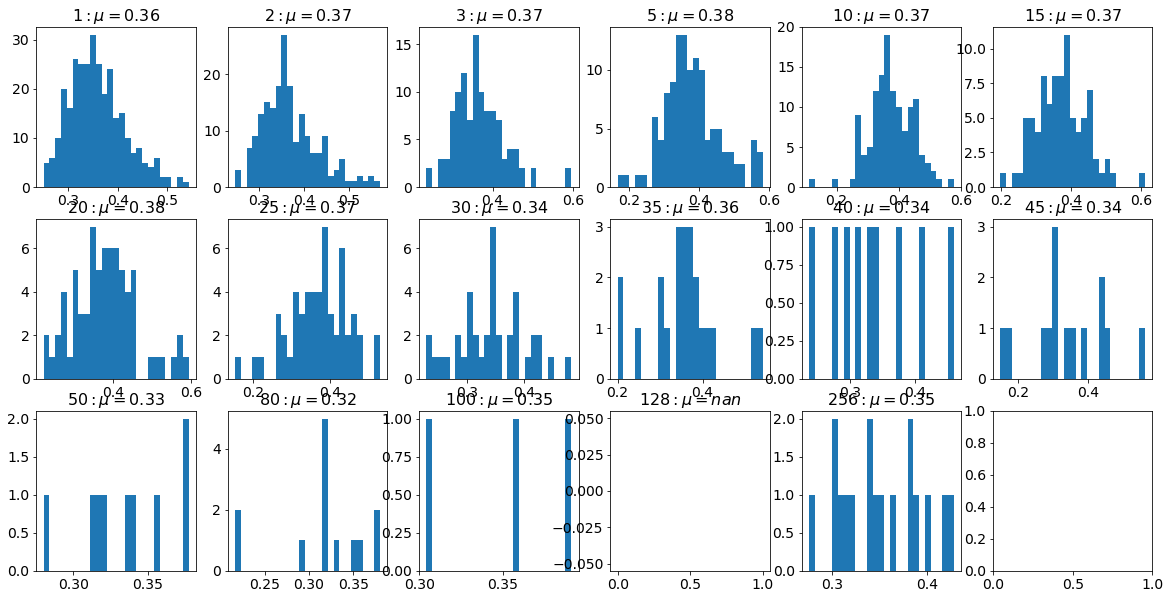

In [199]:
f, ax = plt.subplots(3,6, figsize=(20,10))

for i in range(len(filters_range)):
    filter_num = filters_range[i]
    idx = np.where(approx_filters == filter_num)[0]
    ax[i/6][i%6].hist(nearest_in_dist[idx], bins=25, label='$\mu = %.2f$' % np.mean(nearest_in_dist[idx]))
    #ax[i/6][i%6].set_legend()
    ax[i/6][i%6].set_title('$%d: \mu = %.2f$' % (filter_num, np.mean(nearest_in_dist[idx])))
plt.legend()
plt.show()

In [260]:
for filter_num in filters_range:
    print filter_num, label_names[filter_num == approx_filters] 

1 [u'motorbike' u'brick' u'mug' u'buffet' u'cracked' u'cloud' u'scaly'
 u'paisley' u'wrinkled' u'corridor-s' u'cobwebbed' u'wire' u'microphone'
 u'paper towel' u'corner pocket' u'foliage' u'bouquet' u'canister'
 u'helmet' u'beach-s' u'childs_room-s' u'newspaper' u'cross' u'casing'
 u'shower stall' u'swimming pool' u'patty' u'trouser' u'piano' u'arcade'
 u'saucepan' u'forest-needleleaf-s' u'briefcase' u'fire escape' u'cd'
 u'bread' u'youth_hostel-s' u'field-wild-s' u'fuselage' u'grand piano'
 u'earmuffs' u'museum-indoor-s' u'radio' u'riser' u'boot' u'map'
 u'parking_lot-s' u'valley-s' u'auditorium-s' u'balcony-interior-s'
 u'arrival_gate-outdoor-s' u'merchandise' u'ice' u'deck' u'galley-s'
 u'bookstore-s' u'pitch' u'supermarket-s' u'golf_course-s' u'controls'
 u'island' u'greenhouse-indoor-s' u'duck' u'doorway-indoor-s'
 u'access_road-s' u'slope' u'monument' u'trailer' u'windmill'
 u'water tower' u'brushes' u'forest_path-s' u'home_theater-s' u'ocean-s'
 u'tumble dryer' u'harbor-s' u'bow

In [210]:
num_train_examples = np.sum(image_to_label[train_ind,:], axis=0)
idx = np.where(num_train_examples > 100)[0]
idx = idx[1:]

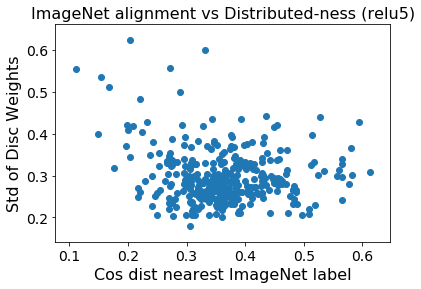

In [224]:
f, ax = plt.subplots(1,1)
#ax.scatter(nearest_in_dist[idx], np.std(norm_weights[idx], axis=1))
ax.scatter(nearest_in_dist[idx], np.std(disc_weights[blob][idx,-1,:], axis=1))
ax.set_xlabel('Cos dist nearest ImageNet label')
ax.set_ylabel('Std of Disc Weights')
ax.set_title('ImageNet alignment vs Distributed-ness (%s)' % blob_names[blob])
plt.show()

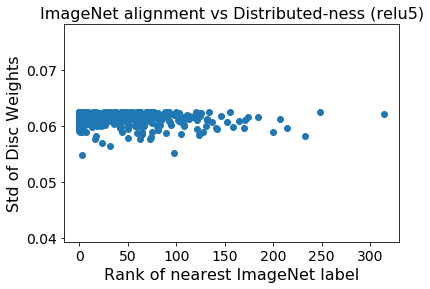

In [216]:
f, ax = plt.subplots(1,1)
ax.scatter(nearest_in_idx[idx], np.std(norm_weights[idx], axis=1))
ax.set_xlabel('Rank of nearest ImageNet label')
ax.set_ylabel('Std of Disc Weights')
ax.set_title('ImageNet alignment vs Distributed-ness (%s)' % blob_names[blob])
plt.show()

In [250]:
norm_weights.shape

(1197, 256)

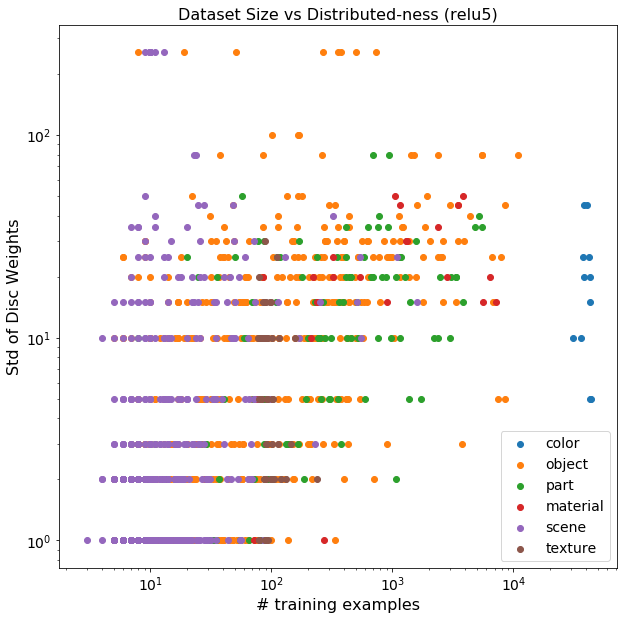

In [259]:
f, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_xscale('log')
ax.set_yscale('log')
for c in range(6):
    #ax.scatter(num_train_examples[pc == c], np.std(norm_weights[pc == c,:], axis=1), label=categories[c])
    #ax.scatter(num_train_examples[pc == c], np.std(disc_weights[blob][pc == c,-1,:], axis=1), label=categories[c])
    ax.scatter(num_train_examples[pc == c], approx_filters[pc == c], label=categories[c])
ax.set_xlabel('# training examples')
ax.set_ylabel('Std of Disc Weights')
ax.set_title('Dataset Size vs Distributed-ness (%s)' % blob_names[blob])
plt.legend()
plt.show()

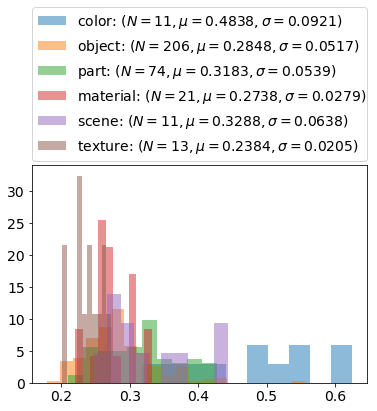

In [269]:
f, ax = plt.subplots(1,1)
for c in range(6):
    #stds = np.std([norm_weights[i] for i in range(1,L) if pc[i] == c and num_train_examples[i] > 100], axis=1)
    stds = np.std([disc_weights[blob][i,-1,:] for i in range(1,L) if pc[i] == c and num_train_examples[i] > 100], axis=1)
    ax.hist(stds, bins=max(len(stds)/10, 10), normed=True, alpha=0.5, 
            label='%s: $(N = %d, \mu = %.4f, \sigma=%.4f)$' % (categories[c], len(stds), np.mean(stds), np.std(stds)))
#ax.set_title('For concepts with dataset size > 100')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)
#plt.legend()
plt.show()

In [222]:
sorted_idx = np.argsort(np.std(disc_weights[blob][idx,-1,:], axis=1))
print label_names[idx[sorted_idx[:50]]]
print label_names[idx[sorted_idx[-50:]]]

[u'pane of glass' u'dotted' u'ladder' u'hill' u'heater' u'vent' u'curb'
 u'meshed' u'brush' u'notebook' u'sash' u'land' u'booklet' u'tower'
 u'hedge' u'post' u'bulletin board' u'mug' u'shower' u'shutter' u'wood'
 u'laptop' u'coffee maker' u'wicker' u'muntin' u'perforated' u'can'
 u'banded' u'text' u'pitcher' u'striped' u'kettle' u'umbrella' u'bumpy'
 u'backpack' u'beam' u'metal shutter' u'jar' u'case' u'candle' u'backplate'
 u'board' u'bar' u'step' u'bush' u'screen door' u'shoe' u'porous'
 u'doorframe' u'pitted']
[u'seat cushion' u'headlight' u'pillow' u'curtain' u'armchair' u'wing'
 u'sofa' u'body' u'black-c' u'column' u'painting' u'streetlight' u'dog'
 u'building' u'lamp' u'cat' u'coffee table' u'shade' u'ground' u'ceiling'
 u'living_room-s' u'neck' u'cushion' u'wheel' u'nose' u'headboard' u'paw'
 u'pink-c' u'eye' u'head' u'bed' u'tail' u'torso' u'car' u'muzzle'
 u'white-c' u'ear' u'sky' u'sidewalk' u'road' u'bedroom-s' u'street-s'
 u'grey-c' u'orange-c' u'brown-c' u'green-c' u'awnin

In [221]:
sorted_idx = np.argsort(np.std(disc_weights[blob][:,-1,:], axis=1))
print label_names[sorted_idx[:50]]
print label_names[sorted_idx[-50:]]

[u'' u'rocking chair' u'panel' u'map' u'fire place' u'mattress' u'tread'
 u'television stand' u'linoleum' u'wet_bar-s' u'baseboard' u'coat'
 u'brushes' u'curtains' u'riser' u'elevator' u'basement-s' u'guardrail'
 u'artists_loft-s' u'blinds' u'folding door' u'sweater' u'folding screen'
 u'exhibitor' u'planter' u'menu' u'display board' u'trestle' u'binder'
 u'rubbish' u'mill' u'fish' u'bottle rack' u'alcove-s' u'leaves' u'patio'
 u'planks' u'pictures' u'boot' u'driveway-s' u'beauty_salon-s' u'workbench'
 u'cannon' u'shop' u'straw' u'cabin' u'lockers' u'bidet' u'pallet' u'ramp']
[u'headlight' u'pillow' u'curtain' u'armchair' u'wing' u'sofa' u'body'
 u'black-c' u'column' u'painting' u'streetlight' u'dog' u'building' u'lamp'
 u'cat' u'coffee table' u'shade' u'ground' u'ceiling' u'living_room-s'
 u'neck' u'cushion' u'wheel' u'nose' u'headboard' u'paw' u'pink-c' u'eye'
 u'head' u'bed' u'tail' u'torso' u'car' u'muzzle' u'white-c' u'ear' u'sky'
 u'sidewalk' u'road' u'bedroom-s' u'street-s' u'ar

In [359]:
dc = pkl.load(open('/scratch/shared/slow/ruthfong/pytorch_alexnet_imagenet/features.11-distance_correlation.pkl', 'rb'))

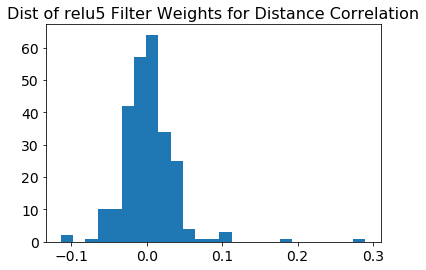

In [366]:
f, ax = plt.subplots(1,1)
ax.hist(dc['act_weights'], bins=25)
ax.set_title('Dist of %s Filter Weights for Distance Correlation' % blob_names[blob])
plt.show()

In [370]:
dc.keys()

['act_weights',
 'nesterov',
 'learning_rate',
 'val_losses',
 'batch_size',
 'concept_weights',
 'blob',
 'num_epochs',
 'directory',
 'train_losses',
 'randomize',
 'momentum']

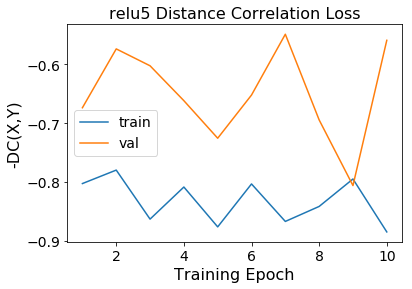

In [372]:
f, ax = plt.subplots(1,1)
ax.plot(range(1,dc['num_epochs']+1), dc['train_losses'], label='train')
ax.plot(range(1,dc['num_epochs']+1), dc['val_losses'], label='val')
ax.set_title('%s Distance Correlation Loss' % blob_names[blob])
ax.set_ylabel('-DC(X,Y)')
ax.set_xlabel('Training Epoch')
plt.legend()
plt.show()

# Reverse Prediction

In [30]:
filter_i = 0
suffix = '_lr_1e-1_bs_16_epochs_1_no_quant_mse_loss'
#suffix = '_lr_1e1_bs_16_epochs_1_bce_loss'

ind_ious_f = ed.open_mmap(blob=blob, part='filter_i_%d_ind_ious%s' % 
                          (filter_i, suffix), mode='r', shape=(N,))
results_f = ed.open_mmap(blob=blob, part='filter_i_%d_results%s' % 
                        (filter_i, suffix), mode='r', shape=(4,1))
weights_f = ed.open_mmap(blob=blob, part='filter_i_%d_weights%s' % 
                        (filter_i, suffix), mode='r', shape=(L-1,))

In [28]:
results_f

memmap([[ 0.5752703 ],
        [ 0.59283239],
        [ 0.12262112],
        [ 0.12263771]], dtype=float32)

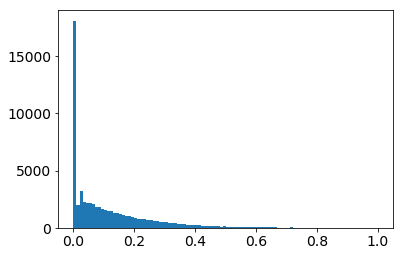

In [314]:
f, ax = plt.subplots(1,1)
ax.hist(ind_ious_f[np.isfinite(ind_ious_f)], bins=100)
plt.show()

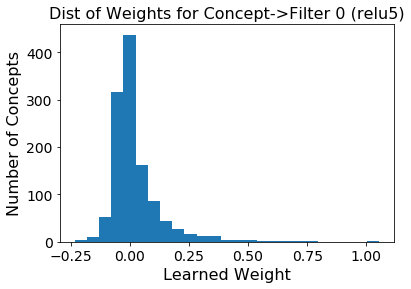

In [316]:
f, ax = plt.subplots(1,1)
ax.hist(weights_f, bins=25)
ax.set_xlabel('Learned Weight')
ax.set_ylabel('Number of Concepts')
ax.set_title('Dist of Weights for Concept->Filter %d (%s)' % (filter_i, blob_names[blob]))
plt.show()

In [317]:
sorted_idx = np.argsort(weights_f)[::-1]
for i in range(20):
    print i+1, label_names[sorted_idx[i+1]], weights_f[sorted_idx[i+1]]

1 bathroom-s 0.786402
2 chair 0.763649
3 column 0.702146
4 fan 0.676523
5 umbrella 0.665537
6 remote control 0.604063
7 house-s 0.598422
8 headboard 0.546348
9 shop window 0.531986
10 living_room-s 0.528626
11 person 0.505612
12 cat 0.465855
13 mouse 0.460079
14 door frame 0.456776
15 bush 0.429728
16 elevator-door-s 0.425449
17 earth 0.424578
18 tearoom-s 0.382936
19 seat base 0.372672
20 cubicle-office-s 0.370737


In [321]:
top[blob].shape

(256, 63305)

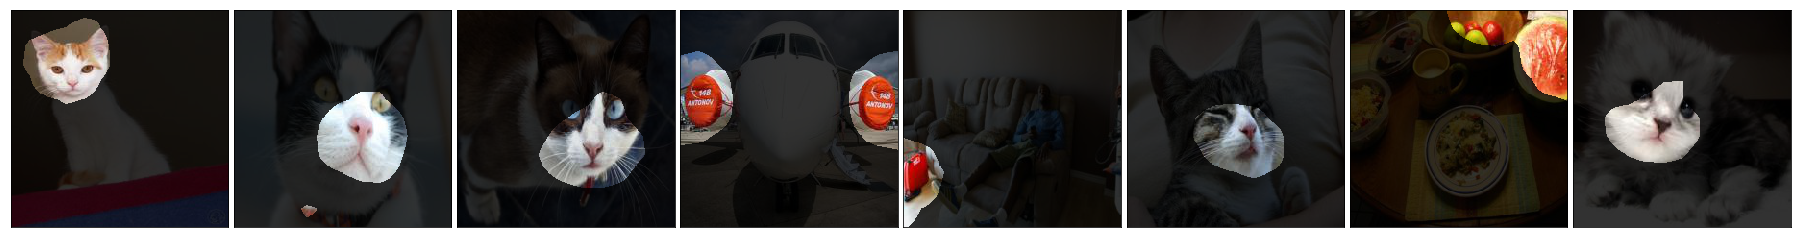

In [322]:
show_examples_for_unit(ds, blobdata, thresh, blob, filter_i, top[blob][filter_i][::-1], 
                      up_size=info.input_dim)

In [331]:
single_set_val_ious[blob].shape

(1198, 256)

In [335]:
for label_i in label_idx[np.where(best_filters == filter_i)[0]]:
    print label_names[label_i], single_set_train_ious[blob][label_i,filter_i], single_set_val_ious[blob][label_i,filter_i]

beak 0.0347146 0.0261775
dishrag 0.0251002 0.0
balloon 0.15851 0.0773176
control tower 0.0 0.0


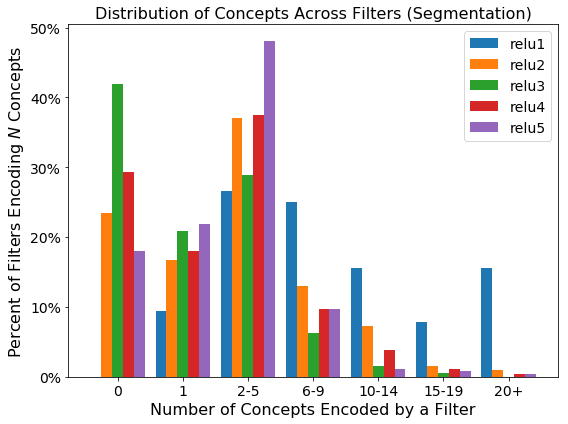

In [325]:
f, ax = plt.subplots(1,1, figsize=(8,6))

ranges = [(0,0), (1,1), (2,5), (6,9), (10,14), (15,19),(20, np.inf)]
idx = np.arange(len(ranges))
width = 1/float(len(blobs)+1)

label_idx = np.array([i for i in range(len(pc)) if (pc[i] < 4 and pc[i] >= 0)])

j = 0
for blob in blobs:
    blob_info = ed.load_info(blob=blob)
    K = blob_info.shape[1]
    best_filters = single_set_train_ious[blob].argmax(axis=1)[label_idx]
    best_filters_count = np.zeros(K)
    for f in range(K):
        best_filters_count[f] = np.sum(best_filters == f)
    ax.bar(idx + j*width, [np.sum(np.logical_and(best_filters_count >= r[0], 
                                         best_filters_count <= r[1]))/float(K) for r in ranges], 
           width, label=blob_names[blob])
    j += 1
ax.legend()
ax.set_title('Distribution of Concepts Across Filters (Segmentation)')
ax.set_xticks(idx+width*(len(blobs)-1)/2.)
ax.set_xticklabels(['0','1','2-5','6-9','10-14','15-19','20+'])
ax.set_xlabel('Number of Concepts Encoded by a Filter')
ax.set_ylabel(r'Percent of Filters Encoding $N$ Concepts')
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

# Multi-Filter, Multi-Concept

In [17]:
import pickle as pkl

In [18]:
results = pkl.load(open('/scratch/shared/slow/ruthfong/pytorch_alexnet_imagenet/multi_features.11_all_samples_10_components.pkl', 'rb'))
#results = pkl.load(open('/scratch/shared/slow/ruthfong/pytorch_alexnet_imagenet/multi_features.11_all_samples_2_components.pkl', 'rb'))
#results = pkl.load(open('/scratch/shared/slow/ruthfong/pytorch_alexnet_imagenet/multi_features.11_5000_samples_2_components.pkl', 'rb'))

In [19]:
num_components = 10
cca_suffix = '_multi_features_all_samples_%d_components' % num_components
cca_imgmax = ed.open_mmap(blob=blob, part='linear_imgmax%s' % cca_suffix, mode='r', shape=(N,num_components))
cca_top = cca_imgmax.argsort(axis=0).transpose()[::-1]

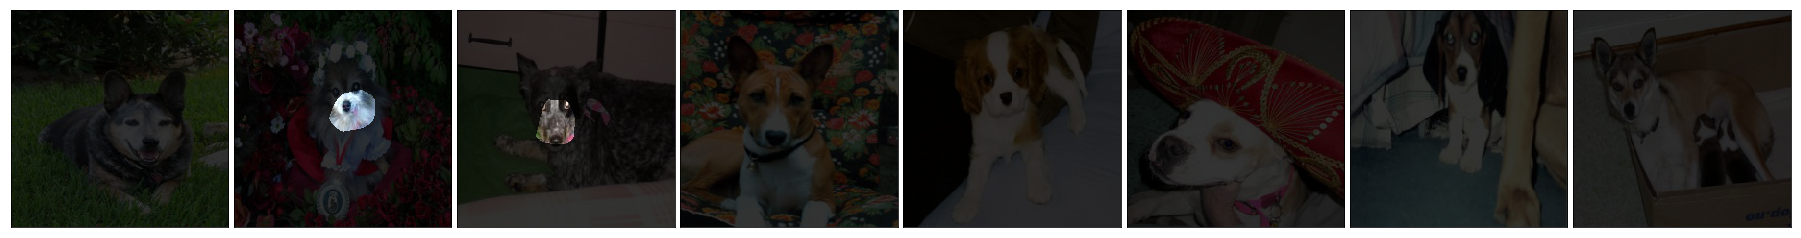

In [20]:
component = 9
show_examples_for_unit(ds, blobdata, thresh, blob, component, cca_top[component][::-1], 
                      up_size=info.input_dim)

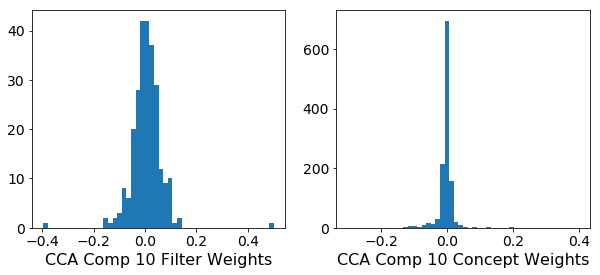

15 0.50198556851
114 0.138715732418
95 0.136550291682
9 0.113150272269
152 0.104692195829
162 0.104184328148
66 0.102349329336
217 0.0972483530584
105 0.0971053312704
250 0.0937344641924


gate 0.397649125809
freckled 0.227829614851
sprinkled 0.203277665416
column 0.190518090598
mountain_snowy-s 0.188030099185
rack 0.172868590197
cracked 0.130423046931
fan 0.122725101652
ear 0.111477913194
hill 0.0960280224265
blue-c 0.0890841822374
wall 0.0839198596222
truck 0.083774180431
shade 0.0646598587677
can 0.0552285159443
brown-c 0.0504993921772
windowpane 0.0463025864167
work surface 0.0438084756674
desk 0.0425865967922
train 0.0421081853324


In [21]:
#component = 6
m = results['model']

f, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(m.x_weights_[:,component], bins=50)
ax[0].set_xlabel('CCA Comp %d Filter Weights' % (component+1))
ax[1].hist(m.y_weights_[:,component], bins=50)
ax[1].set_xlabel('CCA Comp %d Concept Weights' % (component+1))
plt.show()

sorted_idx = np.argsort(m.x_weights_[:,component])[::-1]
for i in range(10):
    print sorted_idx[i], m.x_weights_[sorted_idx[i],component]
    
print('\n')

sorted_idx = np.argsort(m.y_weights_[:,component])[::-1]
for i in range(20):
    print label_names[sorted_idx[i]], m.y_weights_[sorted_idx[i],component]

In [345]:
ind = 0
print m.y_weights_[np.where(np.abs(m.y_weights_[:,ind]) > 0.1)[0],0]
print label_names[np.where(np.abs(m.y_weights_[:,ind]) > 0.1)[0]]

[ 0.23930378  0.23734547  0.54626557  0.47924443  0.23826716  0.19891545
 -0.14280237  0.18941343  0.1780658   0.10167645]
[u'painted' u'tail' u'column' u'stairs' u'desk' u'fan' u'motorbike' u'can'
 u'hill' u'crane']


In [ ]:
concept_data[:,0]

In [23]:
from upsample_blob_data import get_seg_size

blob = 'features.11'
blob_info = ed.load_info(blob=blob)
shape = blob_info.shape
seg_size = get_seg_size(info.input_dim)
upsampled_data = ed.open_mmap(blob=blob, part='upsampled', mode='r',
                                  shape=(shape[0], shape[1], seg_size[0], seg_size[1]))
concept_data = ed.open_mmap(part='concept_data', mode='r',
                                  shape=(N, L, seg_size[0], seg_size[1]))

In [24]:
from sklearn.cross_decomposition import CCA

h = seg_size[0]/2
w = seg_size[0]/2

X = upsampled_data[:1000,:,h,w]
Y = concept_data[:1000,:,h,w]

cca = m

X_c, Y_c = cca.transform(X, Y)

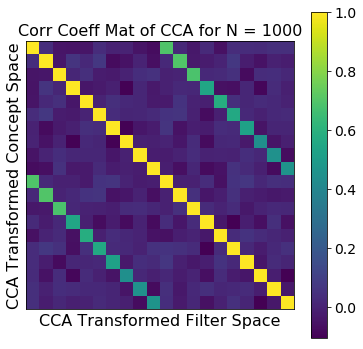

In [25]:
f, ax = plt.subplots(1,1,figsize=(6,6))
cax = ax.imshow(np.corrcoef(X_c.T,Y_c.T))
f.colorbar(cax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('CCA Transformed Filter Space')
ax.set_ylabel('CCA Transformed Concept Space')
ax.set_title('Corr Coeff Mat of CCA for N = 1000')
plt.show()

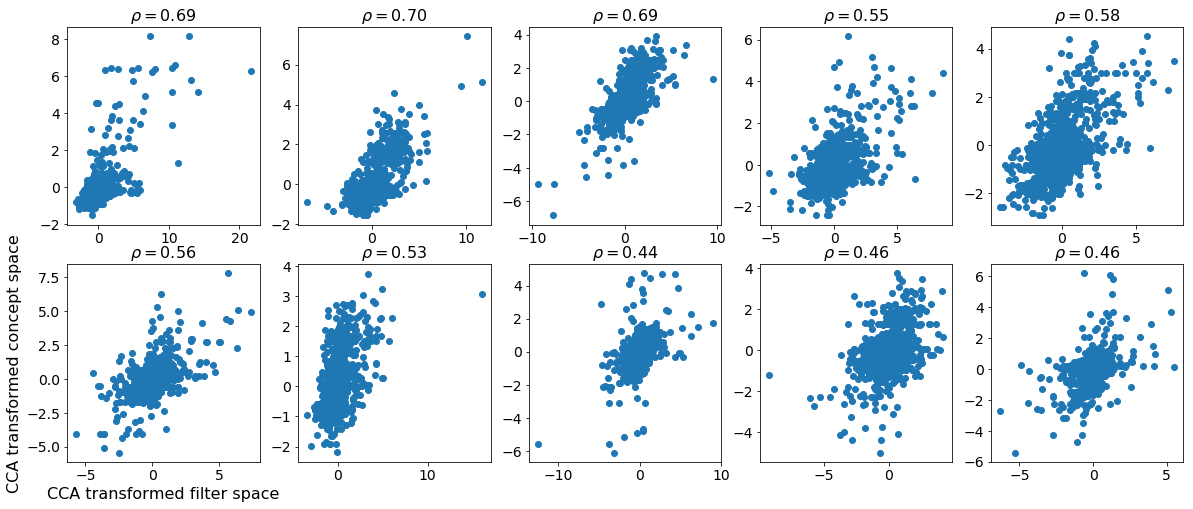

In [26]:
f, ax = plt.subplots(2,5, figsize=(20,8))
for i in range(num_components):
    ax[i/5][i%5].scatter(X_c[:,i],Y_c[:,i])
    (rho, pv) = pearsonr(X_c[:,i],Y_c[:,i])
    ax[i/5][i%5].set_title(r'$\rho = %.2f$' % rho)
ax[1][0].set_xlabel('CCA transformed filter space')
ax[1][0].set_ylabel('CCA transformed concept space')
plt.show()

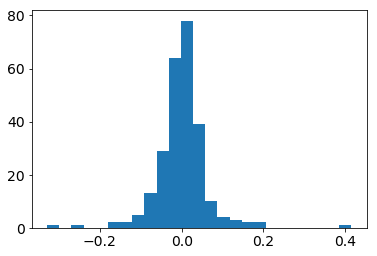

In [22]:
f, ax = plt.subplots(1,1)
ax.hist(cca.x_weights_, 25)
plt.show()

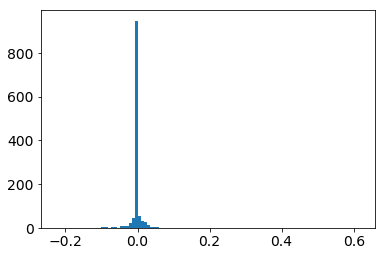

In [24]:
f, ax = plt.subplots(1,1)
ax.hist(cca.y_weights_, 100)
plt.show()

In [30]:
print cca.y_weights_[np.where(np.abs(cca.y_weights_) > 0.1)[0]]
print label_names[np.where(np.abs(cca.y_weights_) > 0.1)[0]]

[[ 0.14691238]
 [ 0.56127909]
 [-0.18084979]
 [-0.22674427]
 [-0.10637472]
 [ 0.10056555]
 [ 0.6178626 ]]
[u'ceiling' u'road' u'tail' u'stairs' u'can' u'bakery-shop-s'
 u'garage-outdoor-s']


In [52]:
loader = loadseg.SegmentationPrefetcher(ds, categories=categories, split='train', once=False, batch_size=64, ahead=16, thread=True)

In [53]:
batch = loader.fetch_batch()

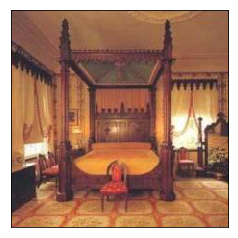

{'color': array([[[ 4,  4,  4, ...,  6,  6,  6],
         [ 4,  4,  4, ...,  4,  4,  4],
         [ 4,  4,  4, ...,  4,  4,  4],
         ..., 
         [ 4, 11, 10, ..., 11, 11, 11],
         [11, 10, 11, ...,  4,  4,  4],
         [11, 10, 10, ...,  4,  4, 11]]], dtype=int16),
 'fn': u'/scratch/local/ssd/ruthfong/NetDissect/dataset/broden1_227/images/ade20k/ADE_train_00003891.jpg',
 'i': 4,
 'material': [],
 'object': array([[[ 0,  0,  0, ..., 25, 25,  0],
         [ 0, 25, 25, ..., 25, 25,  0],
         [ 0, 25, 25, ..., 25, 25,  0],
         ..., 
         [14, 14, 14, ..., 14, 14,  0],
         [14, 14, 14, ..., 14, 14,  0],
         [ 0,  0,  0, ...,  0,  0,  0]]], dtype=int16),
 'part': [],
 'scene': [83],
 'sh': 113,
 'sw': 113,
 'texture': []}

In [67]:
i = 4
show_image(batch[i]['fn'])
batch[i]

In [81]:
ys, xs = np.where(batch[i]['object'][0])

In [92]:
sh = 113
sw = 113
concept_indicator = np.zeros((64,L,sh,sw))

for i in range(64):
    for cat in categories:
        if len(batch[i][cat]) == 0:
            continue
        if cat == 'texture' or cat == 'scene':
            for j in range(len(batch[i][cat])):
                concept_indicator[i][batch[i][cat][j] - 1,:,:] = 1
        else:
            for j in range(len(batch[i][cat])):
                ys, xs = np.where(batch[i][cat][j])
                for k in range(len(ys)):
                    concept_indicator[i][batch[i][cat][j][ys[k]][xs[k]] - 1][ys[k]][xs[k]] = 1

In [94]:
from sklearn.cross_decomposition import CCA
X = blobdata[blob][:64,:,0,0]
Y = concept_indicator[:,:,0,0]
cca = CCA(n_components=1)
cca.fit(X,Y)

X_c, Y_c = cca.transform(X, Y)

In [43]:
Y_c.shape

(1000, 10)

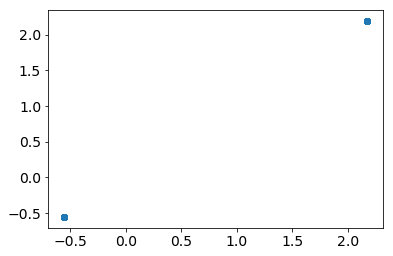

In [106]:
f, ax = plt.subplots(1,1)
ax.scatter(X_c,Y_c)
plt.show()

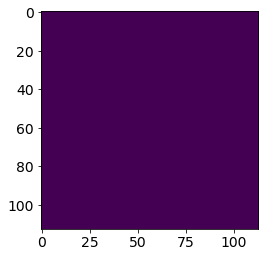

In [90]:
f, ax = plt.subplots(1,1)
ax.imshow(concept_indicator[82])
plt.show()

# Try to Order Images based on Learned Weights

In [18]:
blob = 'features.11'

new_suffix = 'no_thresh_avg_pool'
suffix = '_lr_1e-1_sgd_quant_1_epochs_30_iter_15_num_filters'
linear_disc_imgmax = ed.open_mmap(blob=blob, part='linear_imgmax_disc%s%s' % (suffix, new_suffix), mode='r', shape=(N,L))

In [21]:
linear_disc_top = linear_disc_imgmax.argsort(axis=0).transpose()
linear_top_val = linear_disc_imgmax[val_ind,:].argsort(axis=0).transpose()

In [31]:
top_val = imgmax[blob][val_ind,:].argsort(axis=0).transpose()

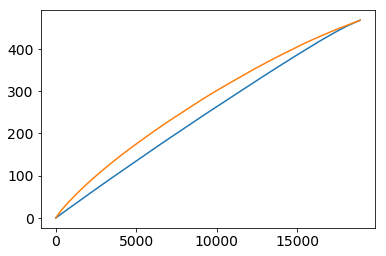

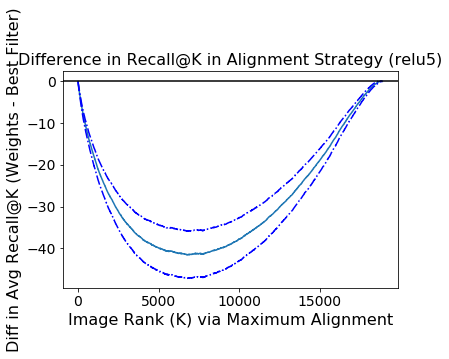

In [32]:
idx = np.array([i for i in range(L) if pc[i] < 4 and pc[i] >= 0])

cum_sum_linear = np.zeros((len(idx), linear_top_val.shape[1]))
cum_sum_single = np.zeros((len(idx), linear_top_val.shape[1]))

for i in range(len(idx)):
    label_i = idx[i]
    best_filter = np.argmax(single_set_train_ious[blob][label_i])

    class_idx_val = np.where(image_to_label[val_ind,label_i])[0]
    class_ind_val = np.zeros(linear_top_val.shape[1])
    class_ind_val[class_idx_val] = 1
    
    cum_sum_linear[i,:] = np.cumsum(class_ind_val[linear_top_val[label_i,:][::-1]])
    cum_sum_single[i,:] = np.cumsum(class_ind_val[top_val[best_filter,:][::-1]])

f, ax = plt.subplots(1,1)
ax.plot(np.mean(cum_sum_linear, axis=0))
ax.plot(np.mean(cum_sum_single, axis=0))
plt.show()

f, ax = plt.subplots(1,1)
mu = np.mean(cum_sum_linear-cum_sum_single, axis=0)
sigma = np.std(cum_sum_linear-cum_sum_single, axis=0)/np.sqrt(len(idx))
ax.plot(mu)
ax.plot(mu+sigma, 'b-.')
ax.plot(mu-sigma, 'b-.')
ax.axhline(y=0, color='k')
ax.set_xlabel('Image Rank (K) via Maximum Alignment')
ax.set_ylabel('Diff in Avg Recall@K (Weights - Best Filter)')
ax.set_title('Difference in Recall@K in Alignment Strategy (%s)' % blob_names[blob])
plt.show()

person


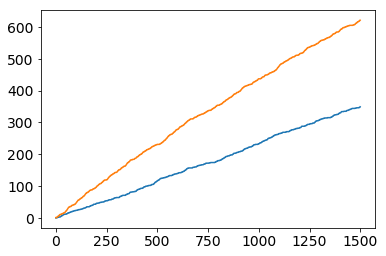

In [33]:
label_i = 19
print label_names[label_i]

best_filter = np.argmax(single_set_train_ious[blob][label_i])

class_idx_val = np.where(image_to_label[val_ind,label_i])[0]
class_ind_val = np.zeros(linear_top_val.shape[1])
class_ind_val[class_idx_val] = 1

f, ax = plt.subplots(1,1)
ax.plot(np.cumsum(class_ind_val[linear_top_val[label_i,:][::-1]][:1500]))
ax.plot(np.cumsum(class_ind_val[top_val[best_filter,:][::-1]][:1500]))
plt.show()

airplane


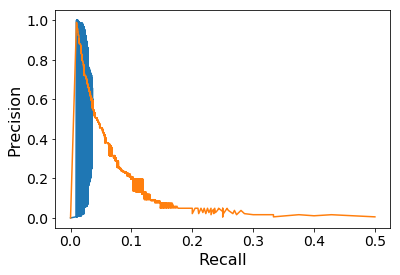

In [34]:
label_i = 154

num_val = linear_top_val.shape[1]

print label_names[label_i]

best_filter = np.argmax(single_set_train_ious[blob][label_i])

class_idx_val = np.where(image_to_label[val_ind,label_i])[0]
class_ind_val = np.zeros(linear_top_val.shape[1])
class_ind_val[class_idx_val] = 1
cum_linear = np.cumsum(class_ind_val[linear_top_val[label_i,:][::-1]])
cum_linear_reverse = np.cumsum(class_ind_val[linear_top_val[label_i,:]])[::-1]

recall_linear = np.true_divide(cum_linear, np.arange(1,num_val+1))
precision_linear = np.true_divide(cum_linear, 
                          cum_linear+cum_linear_reverse)

cum_single = np.cumsum(class_ind_val[top_val[best_filter,:][::-1]])
cum_single_reverse = np.cumsum(class_ind_val[top_val[best_filter,:]])[::-1]

recall_single = np.true_divide(cum_single, np.arange(1,num_val+1))
precision_single = np.true_divide(cum_single, 
                          cum_single+cum_single_reverse)

f, ax = plt.subplots(1,1)
sorted_linear = np.argsort(recall_linear)
sorted_single = np.argsort(recall_single)
ax.plot(recall_linear[sorted_linear], precision_linear[sorted_linear])
ax.plot(recall_single[sorted_single], precision_single[sorted_single])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.show()

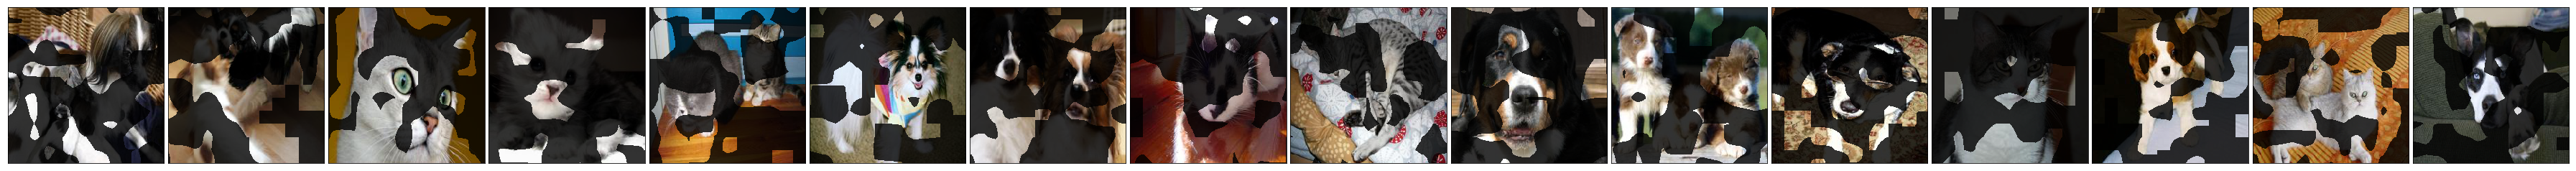

In [51]:
thresh_first = True
interested_classes = [19]
for i in range(len(interested_classes)):
    label_i = interested_classes[i]
    show_examples_for_linear(ds, blobdata, thresh, blob, disc_weights[blob][label_i,-1,:], linear_disc_top[label_i][::-1], up_size=info.input_dim, 
                             num_to_show=16, mask_alpha=0.2, thresh_first=thresh_first)